In [276]:
import pandas as pd
import numpy as np
import mlxtend

from mlxtend.plotting import plot_decision_regions 
from sklearn.model_selection import train_test_split


import seaborn as sns
# from sklearn.preprocessing import LabelEncoder


from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVC

from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# To fetch financial data
import yfinance as yf




adding feature RSI

In [271]:
# Define function to calculate RSI using Pandas
def calculate_rsi(df, n=14, method="EMA"):
    delta = df["Close"].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    if method == "SMA":
        avg_gain = gain.rolling(n).mean()
        avg_loss = loss.rolling(n).mean()
    elif method == "EMA":
        avg_gain = gain.ewm(span=n).mean()
        avg_loss = loss.ewm(span=n).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def label_rsi(rsi):
    if rsi > 70:
        return 1
    elif rsi < 30:
        return 0
    else:
        return 2


In [110]:
# Set the ticker as 'EURUSD=X'
btc_df_o = yf.download('BTC-USD', start='2020-01-01', end='2023-12-31')

# Set the index to a datetime object
btc_df_o.index = pd.to_datetime(btc_df_o.index)

# Display the last five rows
btc_df_o.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-20,26096.861328,26260.681641,26004.314453,26189.583984,26189.583984,9036580420
2023-08-21,26188.691406,26220.201172,25846.087891,26124.140625,26124.140625,13371557893
2023-08-22,26130.748047,26135.507812,25520.728516,26031.656250,26031.656250,14503820706
2023-08-23,26040.474609,26786.898438,25804.998047,26431.640625,26431.640625,16985265785
2023-08-24,26431.800781,26537.068359,25914.925781,25996.285156,25996.285156,14805749760


In [193]:

# Create the plot
fig = go.Figure(go.Scatter(x=btc_df_o.index, y=btc_df_o['Close'], name='Bitcoin Close Price'))

# Customize the plot layout
fig.update_layout(title='Bitcoin Closing Price', xaxis_title='Date', yaxis_title='Price (USD)')

# Display the plot
fig.show()

In [278]:
btc_df=btc_df_o.copy()

# add column RSI
btc_df["RSI"] = calculate_rsi(btc_df)

#Round RSI
btc_df["RSI"]=round(btc_df["RSI"],2)

btc_df = btc_df[['Open', 'High', 'Low', 'Close', 'Volume', 'RSI']]

btc_df = btc_df.drop(btc_df[btc_df["RSI"] == 0] .index)

btc_df = btc_df.dropna(subset=["RSI"], how="any")


btc_df.head()


,Open,High,Low,Close,Volume,RSI
Date,,,,,,
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032,65.89
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275,70.05
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095,70.10
2020-01-06,7410.452148,7781.867188,7409.292969,7769.219238,23276261598,84.12
2020-01-07,7768.682129,8178.215820,7768.227539,8163.692383,28767291327,90.06


In [279]:
# Changes base on shifting data 
#btc_df["Changes"] = btc_df["Close"].shift(-1) > btc_df["Close"]

#btc_df["Changes"] = btc_df["Changes"].astype(int)

btc_df['RSI_Label'] = btc_df['RSI'].apply(label_rsi)

btc_df.head()

,Open,High,Low,Close,Volume,RSI,RSI_Label
Date,,,,,,,
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032,65.89,2
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275,70.05,1
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095,70.10,1
2020-01-06,7410.452148,7781.867188,7409.292969,7769.219238,23276261598,84.12,1
2020-01-07,7768.682129,8178.215820,7768.227539,8163.692383,28767291327,90.06,1


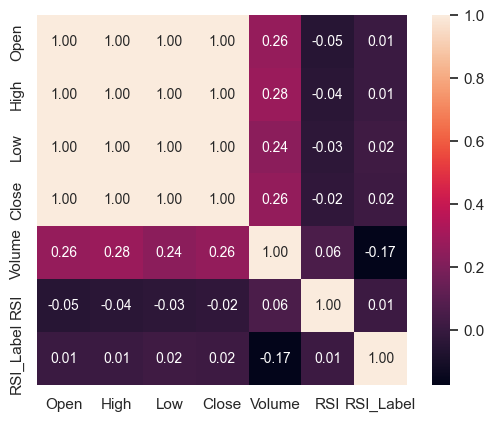

In [280]:
sns.set(style='whitegrid', context='notebook')
cols = btc_df.columns
cm = np.corrcoef(btc_df[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size': 10},yticklabels=cols,xticklabels=cols)
plt.show()

##### Perceptron

In [281]:

# Split the dataset into features and target
x = round(btc_df.drop("RSI_Label", axis=1),2).values
y = btc_df['RSI_Label'].values


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

# Scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

y_train = y_train
y_test = y_test

# Create and train the Perceptron model
ppn = Perceptron(random_state=1, tol=0.001, max_iter=1000)
ppn.fit(X_train, y_train)


# Evaluate the model
train_score = ppn.score(X_train, y_train)
test_score = ppn.score(X_test, y_test)

# Check the Score Result
print(f"Train data score: {train_score:.2f}")
print(f"Test data score: {test_score:.2f}")




Train data score: 0.92
Test data score: 0.92


##### logistic regression Model

In [282]:
# Split the dataset into features and target
x = round(btc_df.drop("RSI_Label", axis=1),2).values
y = btc_df['RSI_Label'].values


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

# Scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

y_train = y_train
y_test = y_test

# Create and train the Perceptron model
lr=LogisticRegression(random_state=1,max_iter=100,tol=0.001)
lr.fit(X_train, y_train)


# Evaluate the model
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

# Check the Score Result
print(f"Train data score: {train_score:.2f}")
print(f"Test data score: {test_score:.2f}")

Train data score: 0.98
Test data score: 0.98


##### SVM


In [283]:

# Split the dataset into features and target
x = round(btc_df.drop("RSI_Label", axis=1),2).values
y = btc_df['RSI_Label'].values


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

# Scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

y_train = y_train
y_test = y_test

# Create and train the Perceptron model

svm=SVC(kernel="rbf",random_state=1)
svm.fit(X_train, y_train)


# Evaluate the model
train_score = svm.score(X_train, y_train)
test_score = svm.score(X_test, y_test)

# Check the Score Result
print(f"Train data score: {train_score:.2f}")
print(f"Test data score: {test_score:.2f}")

Train data score: 0.98
Test data score: 0.98


##### KNN

In [284]:


# Split the dataset into features and target
x = round(btc_df.drop("RSI_Label", axis=1),2).values
y = btc_df['RSI_Label'].values


# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)


# Scale the features
mm = MinMaxScaler()
x_train_mm = mm.fit_transform(x_train)
x_test_mm = mm.transform(x_test)

print(f"length of y_test data > {len(y_test)}")
print(f"Positive diabetes > {y_test.sum()}")
print(f"Negative diabetes > {len(y_test)-y_test.sum()}")

knn=KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train_mm,y_train)

print(f"train_mmm score > {knn.score(x_train_mm,y_train):.2f}")
print(f"test_mmm score > {knn.score(x_test_mm,y_test):.2f}")



length of y_test data > 399
Positive diabetes > 654
Negative diabetes > -255
train_mmm score > 0.88
test_mmm score > 0.88


##### decision tree

trainScore > 0.9795918367346939
test Score > 0.9899749373433584


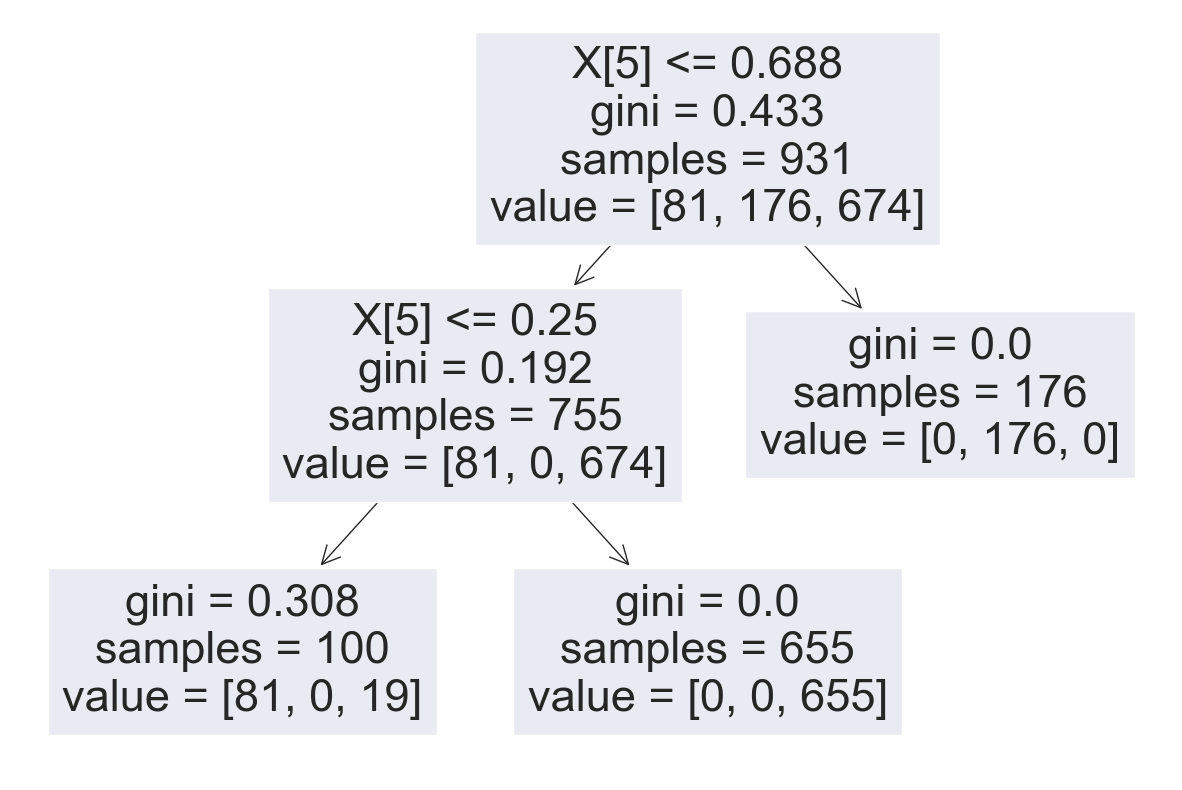

In [291]:


# Split the dataset into features and target
x = round(btc_df.drop("RSI_Label", axis=1),2).values
y = btc_df['RSI_Label'].values


# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)


# Scale the features
mm = MinMaxScaler()
x_train_mm = mm.fit_transform(x_train)
x_test_mm = mm.transform(x_test)


dt=DecisionTreeClassifier(random_state=1,max_depth=6,min_samples_leaf=100,min_samples_split=200)
dt.fit(x_train_mm,y_train)


print("trainScore >",dt.score(x_train_mm,y_train))
print("test Score >",dt.score(x_test_mm,y_test))

plt.figure(figsize=(15,10))
plot_tree(dt)



plt.show()

##### Random forest

In [292]:

# Split the dataset into features and target
x = round(btc_df.drop("RSI_Label", axis=1),2).values
y = btc_df['RSI_Label'].values


# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)



# Scale the features
mm = MinMaxScaler()
x_train_mm = mm.fit_transform(x_train)
x_test_mm = mm.transform(x_test)




rf=RandomForestClassifier(n_estimators=1000,
                          max_features=0.8,
                          min_samples_split=100,
                          random_state=35,
                          max_samples=0.5)
rf.fit(x_train_mm,y_train)


print("trainScore >",rf.score(x_train_mm,y_train))
print("test Score >",rf.score(x_test_mm,y_test))



trainScore > 0.9989258861439313
test Score > 0.9974937343358395
